In [131]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.transforms import blended_transform_factory
import shutil
import pandas as pd
import numpy as np
import ast

In [132]:
import warnings
warnings.filterwarnings("ignore")

### Read all category csv files

In [133]:
topic_csv_dir = "topic_csv"

all_data_df = pd.read_csv(f"{topic_csv_dir}/all_results.csv")
print(f"Loaded file {topic_csv_dir}/all_results.csv with shape {all_data_df.shape}")
# convert Image column value to string
all_data_df["Image"] = all_data_df["Image"].astype(str)

# list all csv files in the directory
csv_files = [f for f in os.listdir(topic_csv_dir) if f != "all_results.csv"]
print(f"Now:, concatenating: {csv_files}")

# read all csv files and concatenate them into one dataframe
all_topic_df = pd.concat([pd.read_csv(os.path.join(topic_csv_dir, f)) for f in csv_files])
all_topic_df["Image"] = all_topic_df["Image"].astype(str)
print(f"Concatenated all csv files into one dataframe with shape {all_topic_df.shape}")

Loaded file topic_csv/all_results.csv with shape (60440, 37)
Now:, concatenating: ['N. Economy and work.csv', 'M. Race and ethnicity.csv', 'Q. Security.csv', 'J. News habits and media.csv', 'D. Politics and policy.csv', 'E. Demographics.csv', 'C. Science and technology.csv', 'L. Family and relationships.csv', 'G. International affairs.csv', 'A. Social values and attitudes.csv', 'I. Gender and LGBTQ.csv', 'B. Religion and spirituality.csv', 'O. Regions and countries.csv', 'K. Immigration and migration.csv', 'P. Methodological research.csv']
Concatenated all csv files into one dataframe with shape (60440, 37)


In [134]:
unique_questions_df = all_topic_df[all_topic_df['Image'] == 'True'][['question_topic', 'question_text', 'md_sim_topic', 'question_topic_mean_similarity','question_topic_country_mean_similarity', 'country']].drop_duplicates()
unique_questions_df = unique_questions_df.groupby(['question_topic', 'country'])
unique_questions_df.head(2)

,question_topic,question_text,md_sim_topic,question_topic_mean_similarity,question_topic_country_mean_similarity,country
1145,N. Economy and work,Do you agree or disagree with the following st...,0.833982,0.643488,0.633922,Brazil
1152,N. Economy and work,Do you agree or disagree with the following st...,0.801163,0.643488,0.633922,Brazil
1265,N. Economy and work,Now I'd like you to tell me your views on vari...,0.707571,0.643488,0.639783,China
1273,N. Economy and work,Do you agree or disagree with the following st...,0.801163,0.643488,0.639783,China
1385,N. Economy and work,Now I'd like you to tell me your views on vari...,0.651969,0.643488,0.658603,France
...,...,...,...,...,...,...
9671,P. Methodological research,"For each of the following aspects, indicate ho...",0.820649,0.614369,0.580117,South Korea
10350,P. Methodological research,In which of the following things do you believ...,0.635679,0.614369,0.620723,United States
10352,P. Methodological research,"Among the following groups of people, how many...",0.663106,0.614369,0.620723,United States
10998,P. Methodological research,Please tell me for each of the following state...,0.695968,0.614369,0.591876,Vietnam


### Plot Question Topic level similarity and JSD values for each country
- This is per country
- Note that all images are for people of same demographic group

In [135]:
all_data_df.columns

Index(['img_id', 'image_path', 'country', 'image_code', 'income',
       'question_text', 'country_prompt', 'generic_prompt', 'option_labels',
       'full_options', 'prompt', 'options', 'top10_token_prob',
       'prob_percent_sorted', 'sum_prob_percent_sorted', 'prob_percent_keys',
       'prob_percent_values', 'selection_answers', 'img_category', 'jsd',
       'similarity', 'Image', 'model_size', 'country_mean_jsd',
       'coutry_mean_similarity', 'question_topic', 'question_topic_mean_jsd',
       'question_topic_mean_similarity',
       'question_topic_country_mean_similarity', 'md_topic_pred',
       'md_topic_gt', 'md_all_pred', 'md_all_gt', 'md_jsd_topic',
       'md_sim_topic', 'md_jsd_overall', 'md_sim_overall'],
      dtype='object')

In [136]:
rich_countries = ["United States", "France", "South Korea", "Italy"]
medium_countries = ["Brazil", "Mexico", "China"]
poor_countries = ["Pakistan", "Nigeria", "Vietnam"]

country_list = rich_countries + medium_countries + poor_countries

In [137]:
# Define the order of countries based on ease of English language usage to different cultural languages
country_order_language = ['United States', 'South Korea', 'France', 'Italy', 'Brazil', 'Mexico', 'China', 'Pakistan', 'Nigeria', 'Vietnam']

# Ensure the country_list is ordered based on the new language order
country_list = sorted(country_list, key=lambda x: country_order_language.index(x))

print(country_list)

['United States', 'South Korea', 'France', 'Italy', 'Brazil', 'Mexico', 'China', 'Pakistan', 'Nigeria', 'Vietnam']


In [138]:
print(all_data_df['Image'].unique())
print(all_topic_df['Image'].dtype)

['False' 'True']
object


Existed! Deleted plots/individual_topic directory


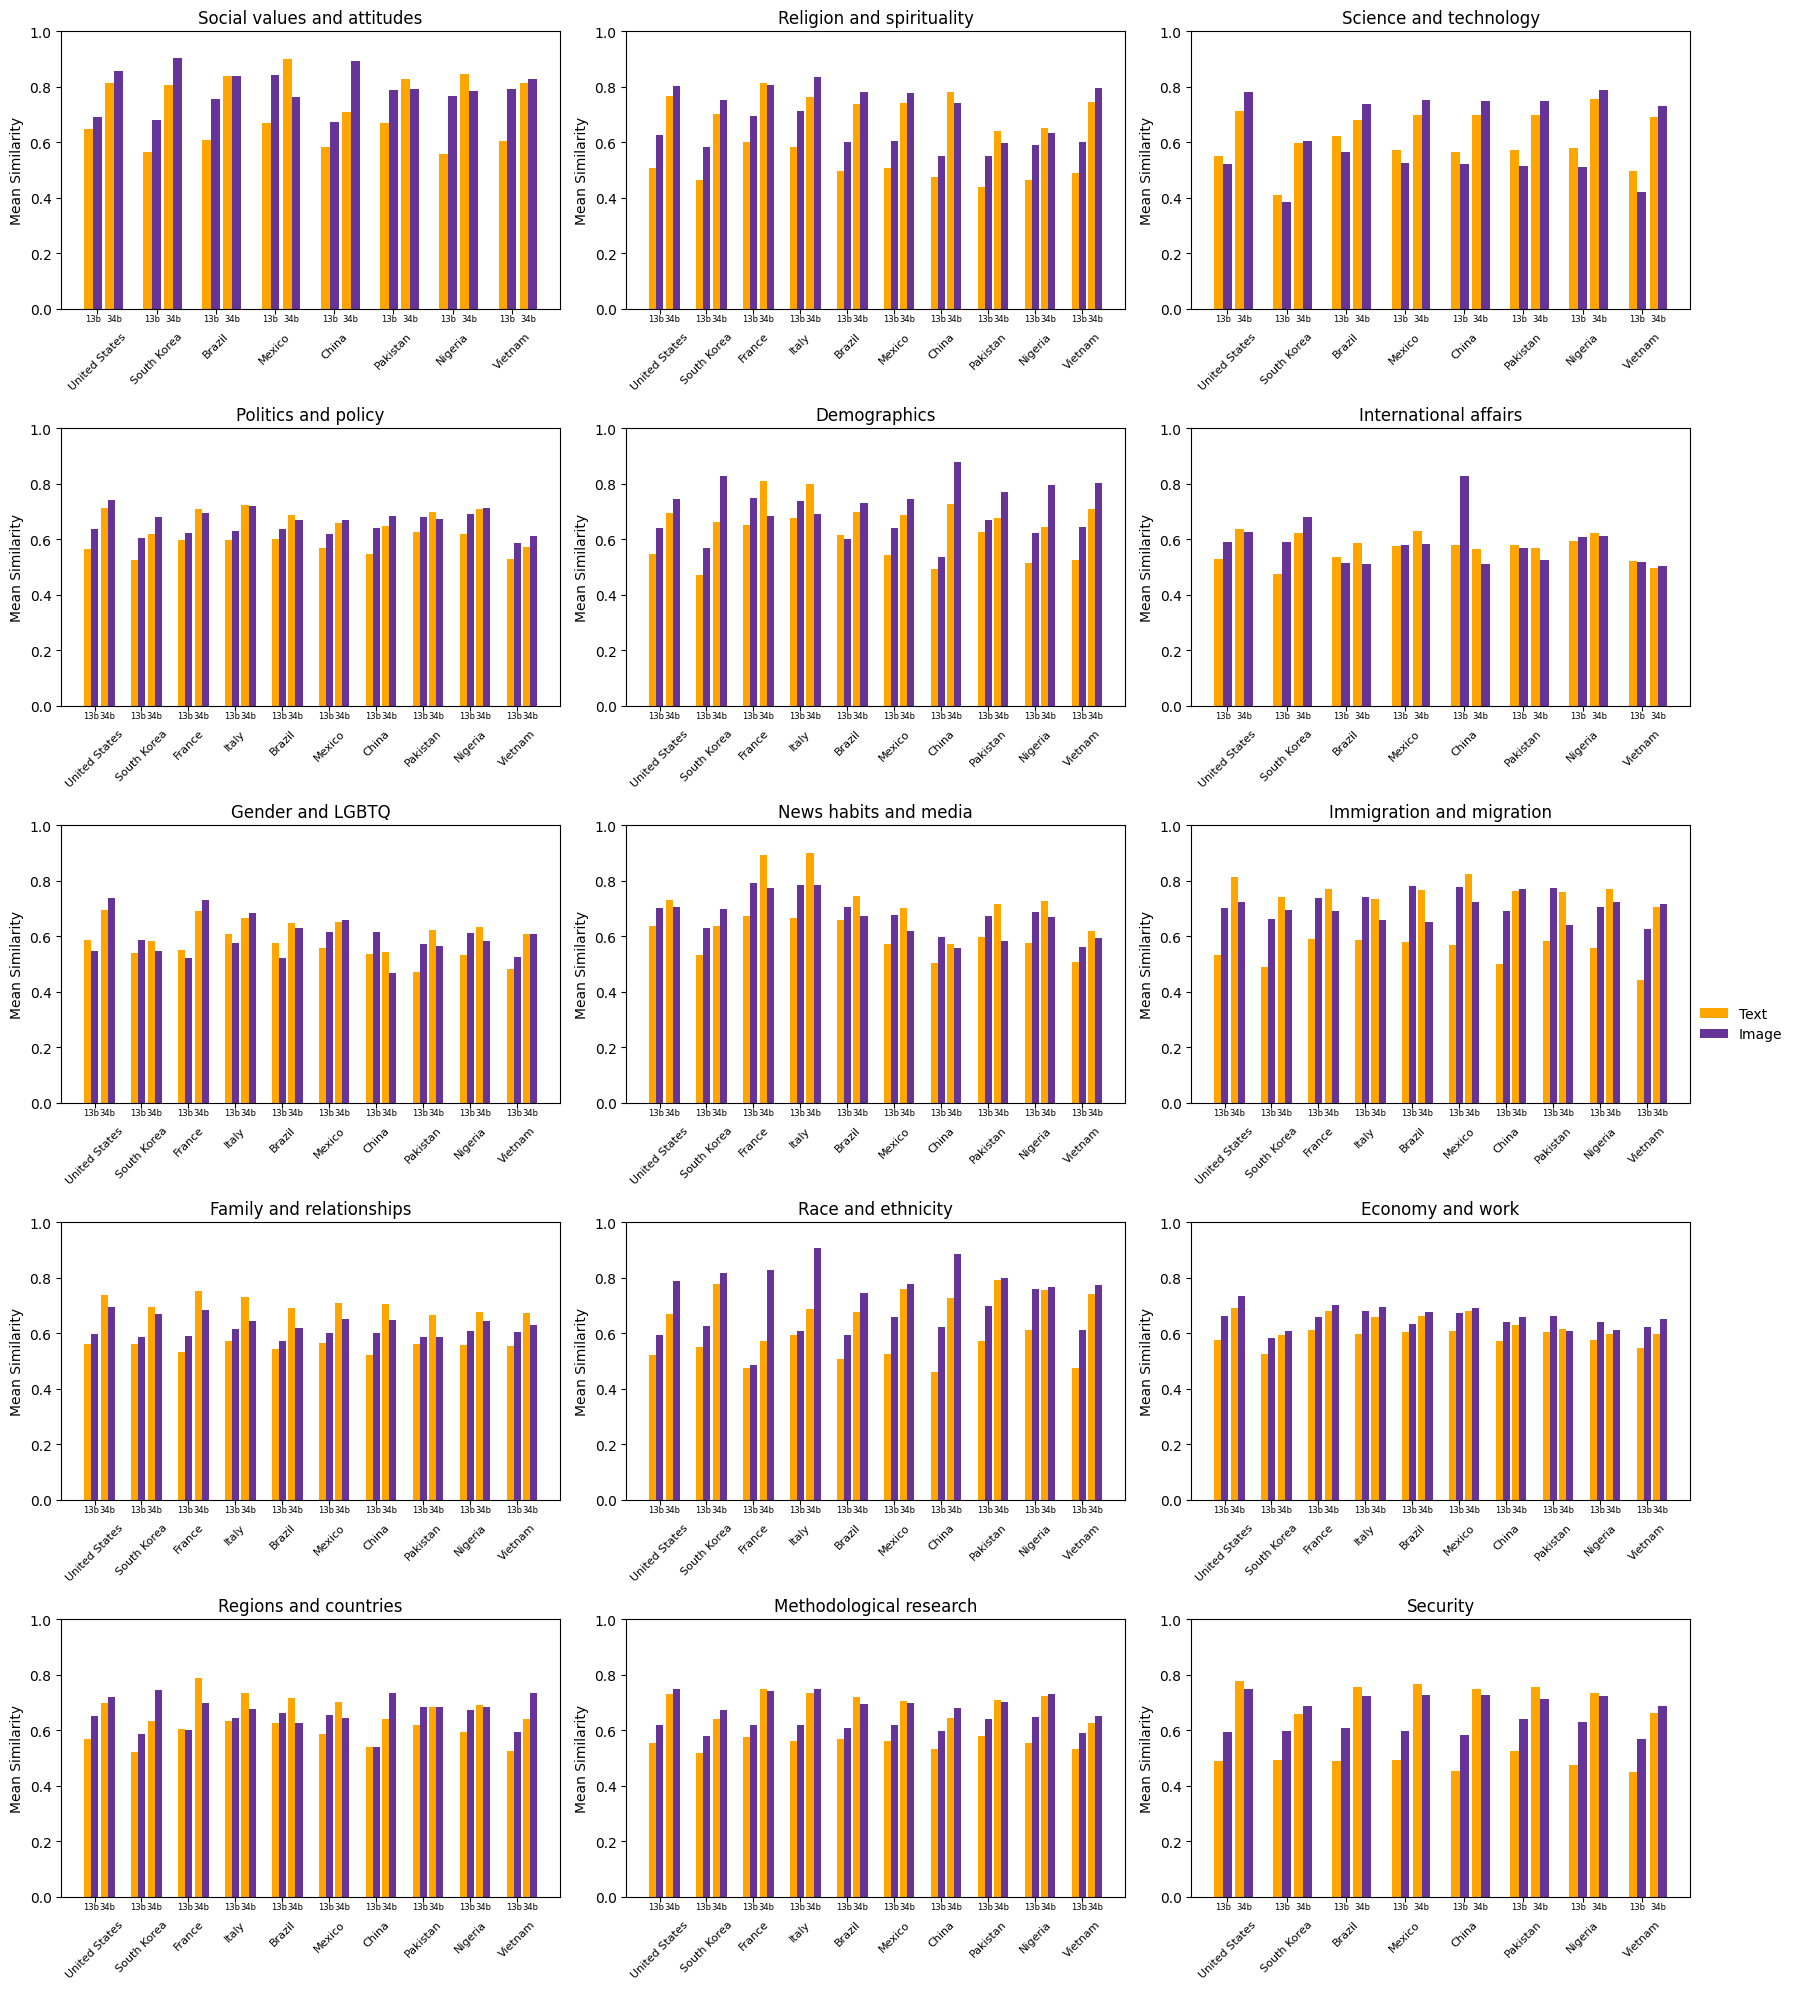

In [139]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.transforms import blended_transform_factory
from tqdm import tqdm

# Directory to save individual figures
individual_figures_dir = 'plots/individual_topic'
if os.path.exists(individual_figures_dir):
    shutil.rmtree(individual_figures_dir)
    print(f"Existed! Deleted {individual_figures_dir} directory")
os.makedirs(individual_figures_dir, exist_ok=True)

# List of unique question topics
question_topics = sorted(all_data_df['question_topic'].unique())
models = sorted(all_data_df['model_size'].unique())

# Prepare for plotting
n_cols = 3  # Number of subplots per row
n_rows = int(np.ceil(len(question_topics) / n_cols))

fig_width = 6 * n_cols
fig_height = 4 * n_rows
fig, axs = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height))
axs = axs.flatten()  # Flatten the array of axes

# Loop through each topic to create subplots
for idx, topic in enumerate(question_topics):
    df_category = all_data_df[all_data_df['question_topic'] == topic]

    # Prepare DataFrame by calculating means for each combination of 'country', 'Image', and 'model_size'
    df_category.loc[:, 'Image'] = df_category['Image'].map({'False': False, 'True': True})
    
    # Calculate mean 'question_topic_mean_similarity' and 'md_sim_topic' per country, Image scenario, and model_size
    df_mean = df_category.groupby(['country', 'Image', 'model_size'])[['question_topic_country_mean_similarity', 'md_sim_topic']].mean().reset_index()

    # Pivot the data to have Image scenarios as columns (Text Similarity, Image Similarity, and Baseline)
    # df_pivot = df_mean.pivot_table(index=['country', 'model_size'], columns='Image', values='question_topic_country_mean_similarity').reset_index()
    # Pivot the data to have Image scenarios as columns (Text Similarity, Image Similarity, and Baseline)
    df_pivot = df_mean.pivot_table(
        index=['country', 'model_size'], 
        columns='Image', 
        values='question_topic_country_mean_similarity'
    ).reset_index()
    
    # Handle the three columns for baseline, text, and image similarity
    # Calculate Baseline Similarity
    baseline_similarity = df_mean[df_mean['Image'] == True].groupby(['country', 'model_size'])['md_sim_topic'].mean().reset_index()
    baseline_similarity = baseline_similarity.rename(columns={'md_sim_topic': 'Baseline Similarity'})

    # Merge Baseline Similarity with df_pivot
    df_pivot = df_pivot.merge(
        baseline_similarity, 
        on=['country', 'model_size'], 
        how='left'
    )
    
    # df_pivot['Baseline Similarity'] = df_pivot['Baseline Similarity'].fillna(0)  # or another appropriate value
    # df_pivot['Baseline Similarity'] = df_mean[df_mean['Image'] == True].groupby(['country', 'model_size'])['md_sim_topic'].mean().values

    # # Drop rows where 'Baseline Similarity' is NaN
    df_pivot = df_pivot.dropna(subset=['Baseline Similarity'])
    df_pivot = df_pivot.rename(columns={False: 'Text Similarity', True: 'Image Similarity'})

    # Ensure all similarity columns exist
    for col in ['Text Similarity', 'Image Similarity', 'Baseline Similarity']:
        if col not in df_pivot.columns:
            df_pivot[col] = np.nan
    
    # breakpoint()
    # Sort countries based on 'country_list'
    df_pivot['country'] = pd.Categorical(df_pivot['country'], categories=country_list, ordered=True)
    df_pivot = df_pivot.sort_values('country')

    # # Drop rows with missing data
    # df_pivot = df_pivot.dropna()
    
    # Create a MultiIndex of all possible combinations
    all_combinations = pd.MultiIndex.from_product(
        [country_list, models],
        names=['country', 'model_size']
    ).to_frame(index=False)

    # Merge with df_pivot to ensure all combinations are present
    df_pivot = all_combinations.merge(df_pivot, on=['country', 'model_size'], how='left')

    # Drop rows with missing data
    df_pivot = df_pivot.dropna()
    
    # Data for plotting
    countries = df_pivot['country'].unique()
    baseline_similarities = df_pivot['Baseline Similarity']
    text_similarities = df_pivot['Text Similarity']
    image_similarities = df_pivot['Image Similarity']
    
    x = np.arange(len(countries))  # Label locations
    width = 0.15  # Width of the bars for each model
    gap_between_models = 0.13  # A larger gap between the two models' sets of bars

    ax = axs[idx]
    
    bigf_has_plotted_text = False
    bigf_has_plotted_image = False
    # Loop through models and plot for each
    for model_idx, model in enumerate(models):
        df_model = df_pivot[df_pivot['model_size'] == model]
        
        # Align df_model to have all countries, but do not fill missing values
        df_model = df_model.set_index('country').reindex(countries).reset_index()
        
        # Drop rows where any of the similarity columns are NaN
        df_model = df_model.dropna(subset=['Text Similarity', 'Image Similarity', 'Baseline Similarity'])
        
        # Recalculate x based on the length of df_model
        x = np.arange(len(df_model))
        
        offset = model_idx * (width * 1.5 + gap_between_models)  # Offset between different models
    
        
        # Plot bars for baseline, text, and image similarity
        # ax.bar(x + offset - width, df_model['Baseline Similarity'], width, label=f'{model} - Baseline')
        if not bigf_has_plotted_text:
            ax.bar(x + offset, df_model['Text Similarity'], width, label='Text', color='orange')
            bigf_has_plotted_text = True
        else:
            ax.bar(x + offset, df_model['Text Similarity'], width, color='orange')
            
        if not bigf_has_plotted_image:
            ax.bar(x + offset + width, df_model['Image Similarity'], width, label=f'Image', color='rebeccapurple')
            bigf_has_plotted_image = True
        else:
            ax.bar(x + offset + width, df_model['Image Similarity'], width, color='rebeccapurple')
        
        # Add model name annotation below the group of bars
        for i in range(len(x)):
            # Calculate the center position for the model label
            center_position = x[i] + offset + width / 2
            ax.text(center_position, -0.02, model, ha='center', va='top', fontsize=6, color='black', transform=ax.get_xaxis_transform())  # Adjust position as needed

    
    # Compute the mean similarity for the topic using text-level data only
    text_mean = df_pivot['Text Similarity'].mean()
    
    # Plot horizontal red dashed line at text_mean
    # ax.axhline(text_mean, color='red', linestyle='--')

    # Annotate the mean value on the plot
    # ax.text(0.01, text_mean, f'{text_mean:.2f}', color='black', ha='left', va='bottom', transform=ax.get_yaxis_transform())
    
    # Remove prefix (e.g., 'A.', 'B.', etc.) from topic name
    topic_title = topic.split('.', 1)[-1].strip()
    
    # Add labels, title, and custom x-axis tick labels
    ax.set_ylabel('Mean Similarity')
    ax.set_title(f'{topic_title}')
    ax.set_xticks(x + width)  # Adjust x-axis to center
    ax.set_xticklabels(countries, rotation=45)  # Set x-tick labels (country names)
    ax.tick_params(axis='x', which='major', labelsize=8, pad=12)  # Adjust font size and appearance
    ax.set_ylim([0, 1])  # Set y-axis limits to [0, 1]
    
    # Create individual figure for the topic
    fig_individual, ax_individual = plt.subplots(figsize=(15, 4))
    
    # Set the width of each bar and define the number of models
    width = 0.15  # Set the width for the bars
    gap_between_models = 0.35  # A larger gap between the two models' sets of bars


    # To ensure only one legend entry per type (Text, Baseline, Image)
    has_plotted_text = False
    # has_plotted_baseline = False
    has_plotted_image = False


    for model_idx, model in enumerate(models):
        df_model = df_pivot[df_pivot['model_size'] == model]
        
        # Align df_model to have all countries, but do not fill missing values
        df_model = df_model.set_index('country').reindex(countries).reset_index()
        
        # Drop rows where any of the similarity columns are NaN
        df_model = df_model.dropna(subset=['Text Similarity', 'Image Similarity', 'Baseline Similarity'])
        
        # Recalculate x based on the length of df_model
        x = np.arange(len(df_model))
        
        # Calculate the offset to center the bars around each x-tick
        if model_idx == 0:
            offset = -gap_between_models / 2
        else:
            offset = gap_between_models / 2
        
        # Plot the Text bars
        if not has_plotted_text:
            ax_individual.bar(x + offset - width / 2, df_model['Text Similarity'], width, label='Text', color='orange')
            has_plotted_text = True
        else:
            ax_individual.bar(x + offset - width / 2, df_model['Text Similarity'], width, color='orange')

        # Plot the Image bars
        if not has_plotted_image:
            ax_individual.bar(x + offset + width / 2, df_model['Image Similarity'], width, label='Image', color='rebeccapurple')
            has_plotted_image = True
        else:
            ax_individual.bar(x + offset + width / 2, df_model['Image Similarity'], width, color='rebeccapurple')
        
        # Add model name annotation below the group of bars
        for i in range(len(x)):
            center_position = x[i] + offset + width / 2
            ax_individual.text(center_position, -0.05, model, ha='center', va='bottom', fontsize=6, color='black')
  
    # Add labels, title, and custom x-axis tick labels
    ax_individual.set_ylabel('Mean Similarity')
    ax_individual.set_title(f'{topic_title}')
    # Set x-ticks to be at the center of the groups of bars
    # The middle point of each set of bars is `x + offset` for the second model, so we can set the x-ticks for that
    x_tick_positions = x + gap_between_models / 2  # Centered at the midpoint of the grouped bars
    ax_individual.set_xticks(x_tick_positions)  # Set x-tick positions
    ax_individual.set_xticklabels(countries)  # Set x-tick labels (country names)
    ax_individual.tick_params(axis='x', which='major', labelsize=10, pad=12)  # Adjust font size and appearance
    # set y max limit to 1
    ax_individual.set_ylim([0, 1])
    ax_individual.yaxis.set_ticks(np.arange(0, 1.1, 0.1))  # Set y-axis ticks in steps of 0.1

    
    # Add legend to individual figure, located in the upper right corner outside the plot area
    ax_individual.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False, fontsize=6)
    
    # Adjust layout to make room for the legend
    fig_individual.tight_layout(rect=[0, 0, 0.8, 1])  # Leave space on the right for the legend
    
    # Save individual figure
    fig_individual.savefig(os.path.join(individual_figures_dir, f'{topic_title}.png'), bbox_inches='tight')
    plt.close(fig_individual)  # Close the figure to free memory
    
# Remove empty subplots if any
for idx in range(len(question_topics), n_rows * n_cols):
    fig.delaxes(axs[idx])

# Adjust layout to make room for the legend
plt.tight_layout(rect=[0, 0, 0.95, 1])  # Leave less space on the right

# Add a single legend on the right
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.0, 0.5), frameon=False)

# Save the final figure with all subplots
fig.savefig(f'{individual_figures_dir}/final_similarity_plot.png', bbox_inches='tight')

plt.show()


### Variance (Difference) of Mean Similarities

In [140]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns


# df = all_data_df.copy() 
# # Mean similarity when Image is True
# mean_sim_with_image = df[df['Image'] == 'True'].groupby(['img_category', 'country'])['similarity'].mean().reset_index()
# mean_sim_with_image.rename(columns={'similarity': 'mean_sim_with_image'}, inplace=True)

# # Mean similarity when Image is False
# mean_sim_without_image = df[df['Image'] == 'False'].groupby(['img_category', 'country'])['similarity'].mean().reset_index()
# mean_sim_without_image.rename(columns={'similarity': 'mean_sim_without_image'}, inplace=True)

# # Step 2: Merge the two DataFrames on 'img_category' and 'country'
# mean_sim = pd.merge(mean_sim_with_image, mean_sim_without_image, on=['img_category', 'country'], how='inner')

# # Step 3: Calculate the variance (difference)
# mean_sim['variance'] = mean_sim['mean_sim_with_image'] - mean_sim['mean_sim_without_image']

# # Step 4: Pivot the DataFrame to create the matrix with categories on y-axis and countries on x-axis
# variance_pivot = mean_sim.pivot(index='img_category', columns='country', values='variance')

# # Optional: Handle missing values in the pivot table
# variance_pivot.fillna(0, inplace=True)

# # Step 5: Plot the variance map using seaborn heatmap
# plt.figure(figsize=(12, 8))
# sns.heatmap(variance_pivot, annot=True, fmt=".2f", cmap='coolwarm', center=0)

# # Customizing the plot
# plt.title('Variance of Mean Similarity Between Image Presence and Absence\n(Mean Similarity With Image - Mean Similarity Without Image)')
# plt.ylabel('Image Category')
# plt.xlabel('Country')

# # Rotate x-axis labels for better readability
# plt.xticks(rotation=45, ha='right')

# plt.tight_layout()
# plt.show()

### Percentage Change in Mean Similarities


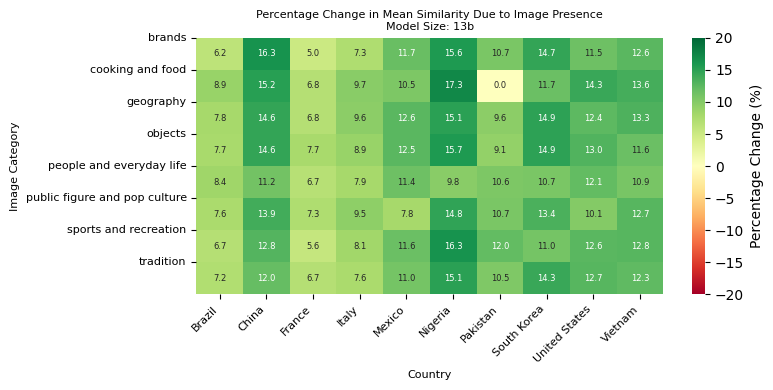

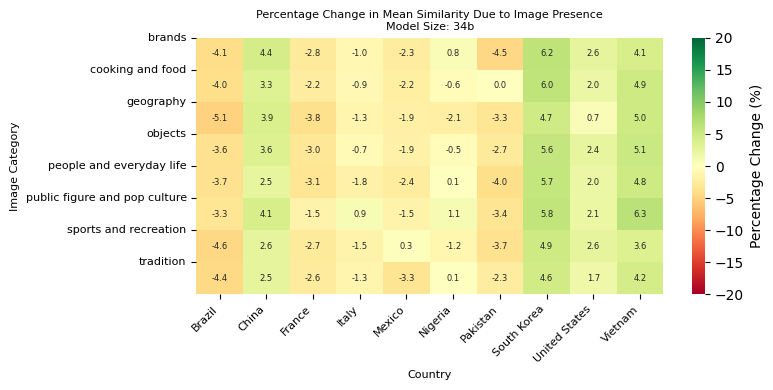

In [141]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = all_data_df.copy()
# Ensure 'Image' column is boolean
df['Image'] = df['Image'].map({'True': True, 'False': False}).astype(bool)

# Get the list of unique model sizes
model_sizes = df['model_size'].unique()

# Loop over each model size and generate the heatmap
for model in model_sizes:
    # Filter the DataFrame for the current model size
    df_model = df[df['model_size'] == model]

    # Step 1: Compute mean similarities with and without images for the current model size

    # Mean similarity when Image is True
    mean_sim_with_image = df_model[df_model['Image'] == True].groupby(['img_category', 'country'])['similarity'].mean().reset_index()
    mean_sim_with_image.rename(columns={'similarity': 'mean_sim_with_image'}, inplace=True)
    
    # Mean similarity when Image is False
    mean_sim_without_image = df_model[df_model['Image'] == False].groupby(['img_category', 'country'])['similarity'].mean().reset_index()
    mean_sim_without_image.rename(columns={'similarity': 'mean_sim_without_image'}, inplace=True)
    
    # Step 2: Merge the two DataFrames
    mean_sim = pd.merge(mean_sim_with_image, mean_sim_without_image, on=['img_category', 'country'], how='inner')
    
    # Step 3: Calculate percentage change
    # Avoid division by zero by replacing zeros in the denominator
    epsilon = 1e-6
    mean_sim['mean_sim_without_image'].replace(0, epsilon, inplace=True)
    
    mean_sim['percentage_change'] = ((mean_sim['mean_sim_with_image'] - mean_sim['mean_sim_without_image']) / mean_sim['mean_sim_without_image']) * 100
    
    # Step 4: Pivot the DataFrame
    percentage_change_pivot = mean_sim.pivot(index='img_category', columns='country', values='percentage_change')
    
    # Optional: Handle infinite values and missing data
    percentage_change_pivot.replace([np.inf, -np.inf], np.nan, inplace=True)
    # replace NaN with 0
    percentage_change_pivot.fillna(0, inplace=True)
    # Clip the data to be within 0% to 100%
    # percentage_change_pivot_clipped = percentage_change_pivot.clip(lower=0, upper=100)
    
    # Step 5: Plot the heatmap with color bar from 0% to 100%
    plt.figure(figsize=(8, 4))
    sns.heatmap(
        percentage_change_pivot,
        annot=True,
        fmt=".1f",
        cmap='RdYlGn',
        vmin=-20,
        vmax=20,
        cbar_kws={'label': 'Percentage Change (%)'},
        annot_kws={"size": 6}  # Change the size of the numbers in the heatmap
    )
    
    # Customizing the plot
    plt.title(f'Percentage Change in Mean Similarity Due to Image Presence\nModel Size: {model}', fontsize=8)
    plt.ylabel('Image Category', fontsize=8)
    plt.xlabel('Country', fontsize=8)
    plt.yticks(ticks=np.arange(len(percentage_change_pivot.index)), labels=[label.replace('_', ' ').lower() for label in percentage_change_pivot.index])
    
    # Rotate x-axis labels
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.yticks(fontsize=8)
    
    plt.tight_layout()
    plt.savefig(f'plots/percentage_change_heatmap_{model}.png', bbox_inches='tight', dpi=500)
    plt.show()


### Ratio of Mean Similarities


In [142]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

# # Step 1 & 2: Compute mean similarities and merge (same as previous methods)

# # Mean similarity when Image is True
# mean_sim_with_image = df[df['Image'] == 'True'].groupby(['img_category', 'country'])['similarity'].mean().reset_index()
# mean_sim_with_image.rename(columns={'similarity': 'mean_sim_with_image'}, inplace=True)

# # Mean similarity when Image is False
# mean_sim_without_image = df[df['Image'] == 'False'].groupby(['img_category', 'country'])['similarity'].mean().reset_index()
# mean_sim_without_image.rename(columns={'similarity': 'mean_sim_without_image'}, inplace=True)

# # Merge the DataFrames
# mean_sim = pd.merge(mean_sim_with_image, mean_sim_without_image, on=['img_category', 'country'], how='inner')

# # Step 3: Calculate the ratio
# # Avoid division by zero by replacing zeros in denominator
# epsilon = 1e-6
# mean_sim['mean_sim_without_image'].replace(0, epsilon, inplace=True)

# mean_sim['similarity_ratio'] = mean_sim['mean_sim_with_image'] / mean_sim['mean_sim_without_image']

# # Handle infinite values
# mean_sim.replace([np.inf, -np.inf], np.nan, inplace=True)

# # Step 4: Pivot the DataFrame
# ratio_pivot = mean_sim.pivot(index='img_category', columns='country', values='similarity_ratio')

# # Optional: Handle missing values
# ratio_pivot.fillna(0, inplace=True)

# # Step 5: Plot the heatmap
# plt.figure(figsize=(12, 8))
# sns.heatmap(ratio_pivot, annot=True, fmt=".2f", cmap='viridis')

# # Customizing the plot
# plt.title('Ratio of Mean Similarities With and Without Image Presence')
# plt.ylabel('Image Category')
# plt.xlabel('Country')

# # Rotate x-axis labels
# plt.xticks(rotation=45, ha='right')

# plt.tight_layout()
# plt.show()


### Percntage Change in Mean Similarities at Question Topic level

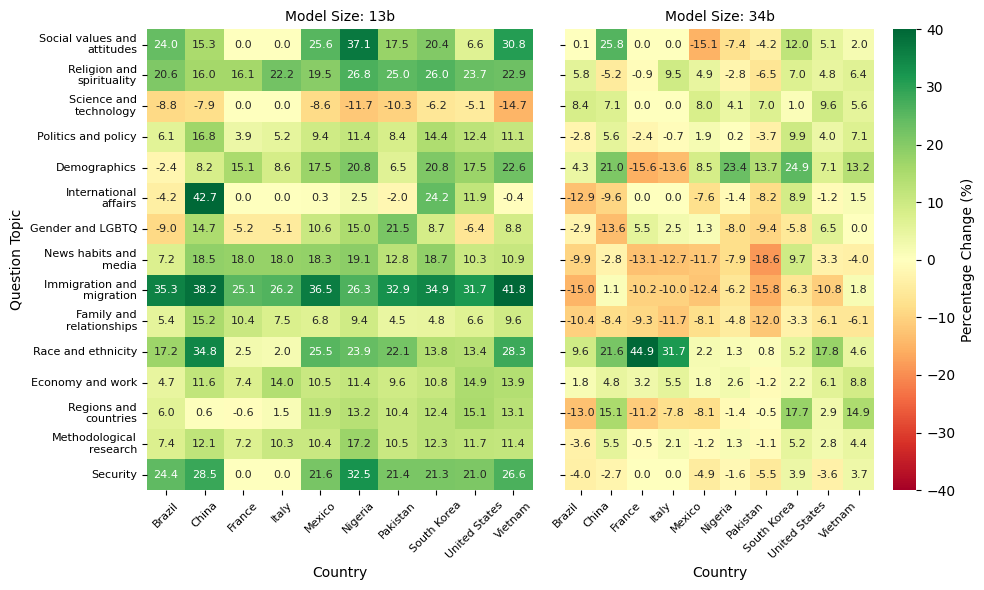

In [143]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from textwrap import wrap

df = all_data_df.copy()
# Ensure 'Image' column is boolean
df['Image'] = df['Image'].map({'True': True, 'False': False}).astype(bool)

# Get the list of unique model sizes
model_sizes = df['model_size'].unique()

# Adjust figure size based on the number of question topics
num_topics = df['question_topic'].nunique()
fig_height = max(8, num_topics * 0.6)

fig_height = 6
# Create a figure with subplots
fig, axes = plt.subplots(1, len(model_sizes), figsize=(10, fig_height), sharey=True)

# Loop over each model size and generate the heatmap
for idx, model in enumerate(model_sizes):
    # Filter the DataFrame for the current model size
    df_model = df[df['model_size'] == model]

    # Compute mean similarities with and without images
    mean_sim_with_image = df_model[df_model['Image'] == True].groupby(['question_topic', 'country'])['similarity'].mean().reset_index()
    mean_sim_with_image.rename(columns={'similarity': 'mean_sim_with_image'}, inplace=True)
    
    mean_sim_without_image = df_model[df_model['Image'] == False].groupby(['question_topic', 'country'])['similarity'].mean().reset_index()
    mean_sim_without_image.rename(columns={'similarity': 'mean_sim_without_image'}, inplace=True)
    
    # Merge the two DataFrames
    mean_sim = pd.merge(mean_sim_with_image, mean_sim_without_image, on=['question_topic', 'country'], how='inner')
    
    # Calculate percentage change
    epsilon = 1e-6
    mean_sim['mean_sim_without_image'].replace(0, epsilon, inplace=True)
    mean_sim['percentage_change'] = ((mean_sim['mean_sim_with_image'] - mean_sim['mean_sim_without_image']) / mean_sim['mean_sim_without_image']) * 100
    
    # Pivot the DataFrame
    percentage_change_pivot = mean_sim.pivot(index='question_topic', columns='country', values='percentage_change')
    
    # Handle infinite values and missing data
    percentage_change_pivot.replace([np.inf, -np.inf], np.nan, inplace=True)
    percentage_change_pivot.fillna(0, inplace=True)
    # percentage_change_pivot_clipped = percentage_change_pivot.clip(lower=0, upper=100)
    percentage_change_pivot_clipped = percentage_change_pivot
    
    # Plot the heatmap in the subplot
    sns.heatmap(
        percentage_change_pivot_clipped,
        annot=True,
        fmt=".1f",
        cmap='RdYlGn',
        vmin=-40,
        vmax=40,
        cbar=(idx == len(model_sizes) - 1),  # Show color bar only on the last subplot
        ax=axes[idx],
        cbar_kws={'label': 'Percentage Change (%)'} if idx == len(model_sizes) - 1 else None,
        annot_kws={"size": 8}
    )
    
    # Customize the subplot
    axes[idx].set_title(f'Model Size: {model}', fontsize=10)
    axes[idx].set_xlabel('Country')
    if idx == 0:
        axes[idx].set_ylabel('Question Topic')
    else:
        axes[idx].set_ylabel('')
    
    # Rotate x-axis labels
    axes[idx].tick_params(axis='x', rotation=45, labelsize=8)
    # Adjust y-axis labels font size
    axes[idx].tick_params(axis='y', labelsize=8)

    # Adjust wrap width based on label length
    wrapped_labels = ['\n'.join(wrap(label.split('. ', 1)[-1], 20)) for label in percentage_change_pivot_clipped.index]
    axes[idx].set_yticklabels(wrapped_labels, fontsize=8, rotation=0)

plt.xticks(rotation=45, ha='right')
plt.yticks(fontsize=8)

plt.tight_layout()
plt.show()
